In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.reasoner_mod import *
from src.generate import load_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *
import random

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
random.seed(seed)
trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')

train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count, batch_size=batch_size, identities_weight=0.4, identitity_weight_decay=0.84)

created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
train epoch 00/15 | batch 2001/2000 | loss 3.8242 | val loss 0.7716 | acc 0.2131 | f1 0.3514 | prec 0.2131 | recall 1.0000 | roc auc 0.5142 | pr auc 0.2463 | elapsed 31.24s
train epoch 01/15 | batch 2001/2000 | loss 2.1223 | val loss 0.7616 | acc 0.5056 | f1 0.3388 | prec 0.2369 | recall 0.5944 | roc auc 0.6160 | pr auc 0.4371 | elapsed 85.36s
train epoch 02/15 | batch 2001/2000 | loss 1.1848 | val loss 0.6218 | acc 0.6377 | f1 0.4289 | prec 0.3229 | recall 0.6384 | roc auc 0.7193 | pr auc 0.5415 | elapsed 88.39s
train epoch 03/15 | batch 2001/2000 | loss 0.9159 | val loss 0.5113 | acc 0.7300 | f1 0.5325 | prec 0.4220 | recall 0.7214 | roc auc 0.8110 | pr auc 0.6709 | elapsed 91.24s
train epoch 04/15 | batch 2001/2000 | loss 0.7264 | val loss 0.4250 | acc 0.7949 | f1 0.6150 | prec 0.5125 | recall 0.7686 | roc auc 0.8649 | pr auc 0.7753 | elapsed 91.55s
train epoch 05/15 | batch 2001/2000 | loss 0.5745 |

In [4]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
random_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner), ('random reasoner', random_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    if reasoner_name == 'trained reasoner':
        train_mod(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)
    #else:
        #train(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner


train epoch 00/10 | batch 1251/1250 | loss 1.2545 | val loss 1.2545 | acc 0.6544 | f1 0.3967 | prec 0.3197 | recall 0.5225 | roc auc 0.6473 | pr auc 0.4467 | elapsed 12.44s
train epoch 01/10 | batch 1251/1250 | loss 1.0522 | val loss 0.8179 | acc 0.7384 | f1 0.4813 | prec 0.4230 | recall 0.5582 | roc auc 0.7342 | pr auc 0.5529 | elapsed 27.62s
train epoch 02/10 | batch 1251/1250 | loss 0.6913 | val loss 0.5352 | acc 0.8119 | f1 0.5872 | prec 0.5616 | recall 0.6153 | roc auc 0.8187 | pr auc 0.6680 | elapsed 28.29s
train epoch 03/10 | batch 1251/1250 | loss 0.4649 | val loss 0.3662 | acc 0.8654 | f1 0.6869 | prec 0.6948 | recall 0.6792 | roc auc 0.8842 | pr auc 0.7756 | elapsed 27.68s
train epoch 04/10 | batch 1251/1250 | loss 0.3296 | val loss 0.2663 | acc 0.9005 | f1 0.7633 | prec 0.7903 | recall 0.7382 | roc auc 0.9267 | pr auc 0.8534 | elapsed 27.40s
train epoch 05/10 | batch 1251/1250 | loss 0.2486 | val loss 0.2059 | acc 0.9231 | f1 0.8154 | prec 0.8529 | recall 0.7812 | roc auc 0.

In [5]:
with T.no_grad():
    idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch_mod(trained_reasoner, trained_test_encoders['trained reasoner'], X_te, y_te, idx_te)
    #_, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240709T201000


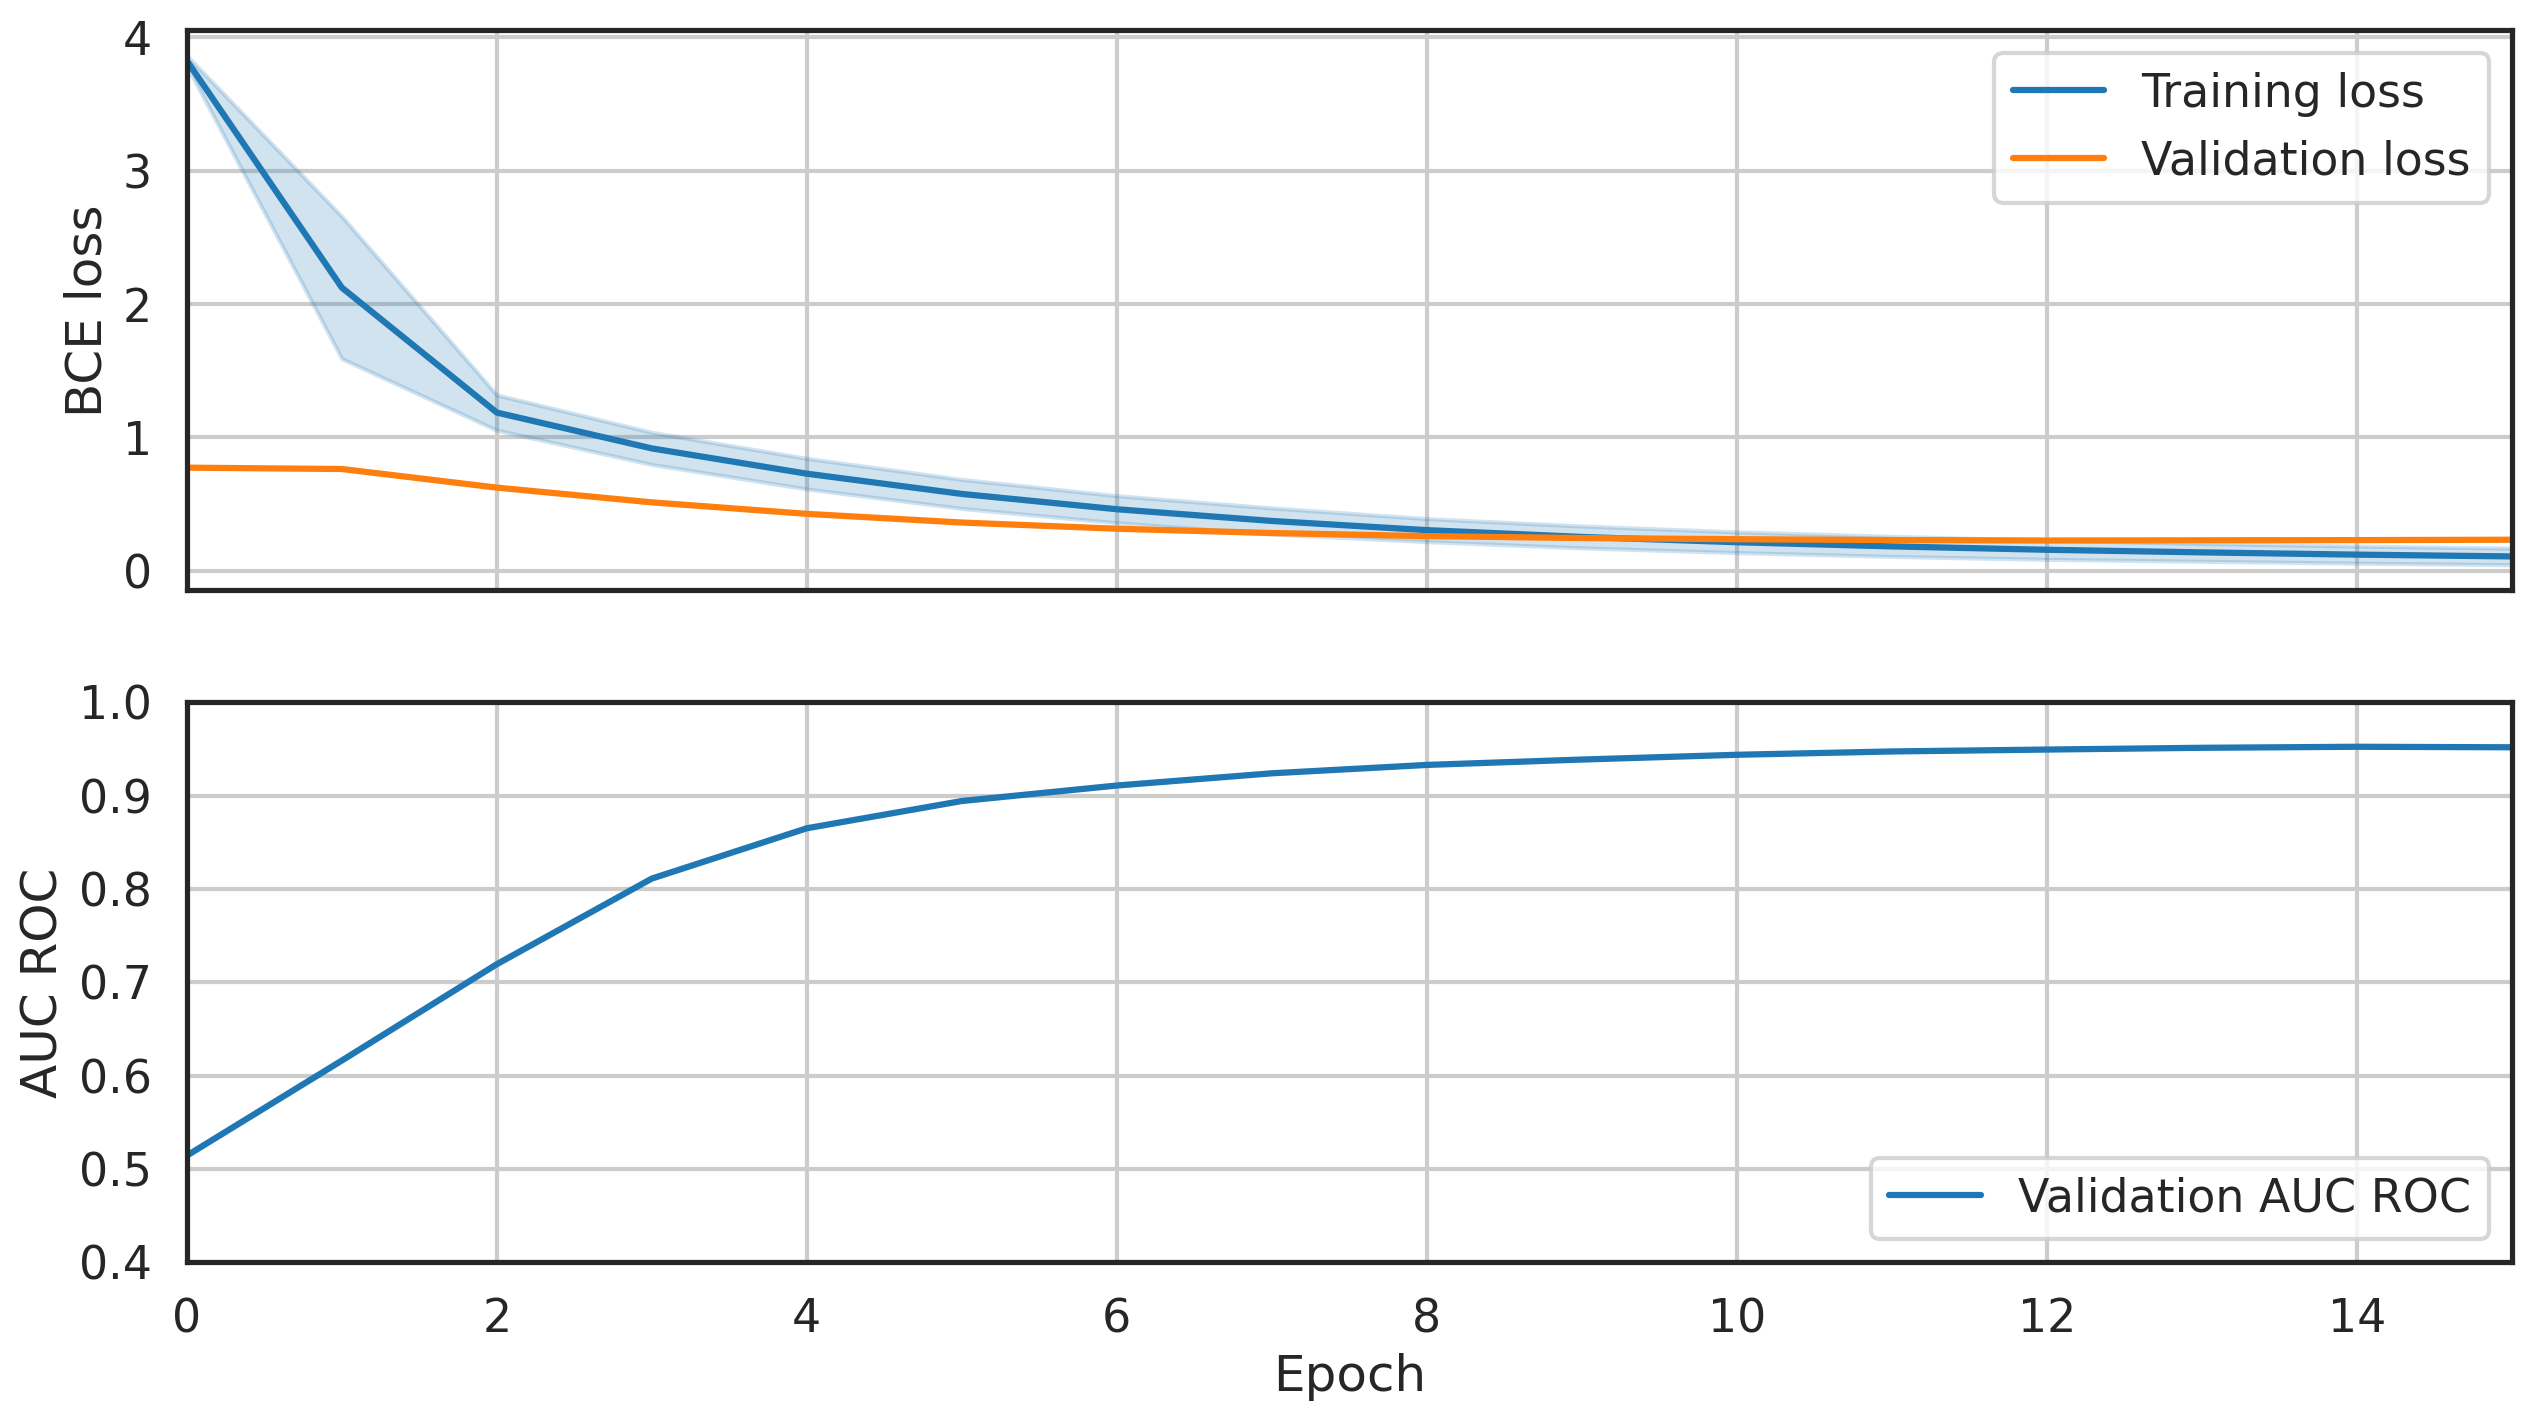

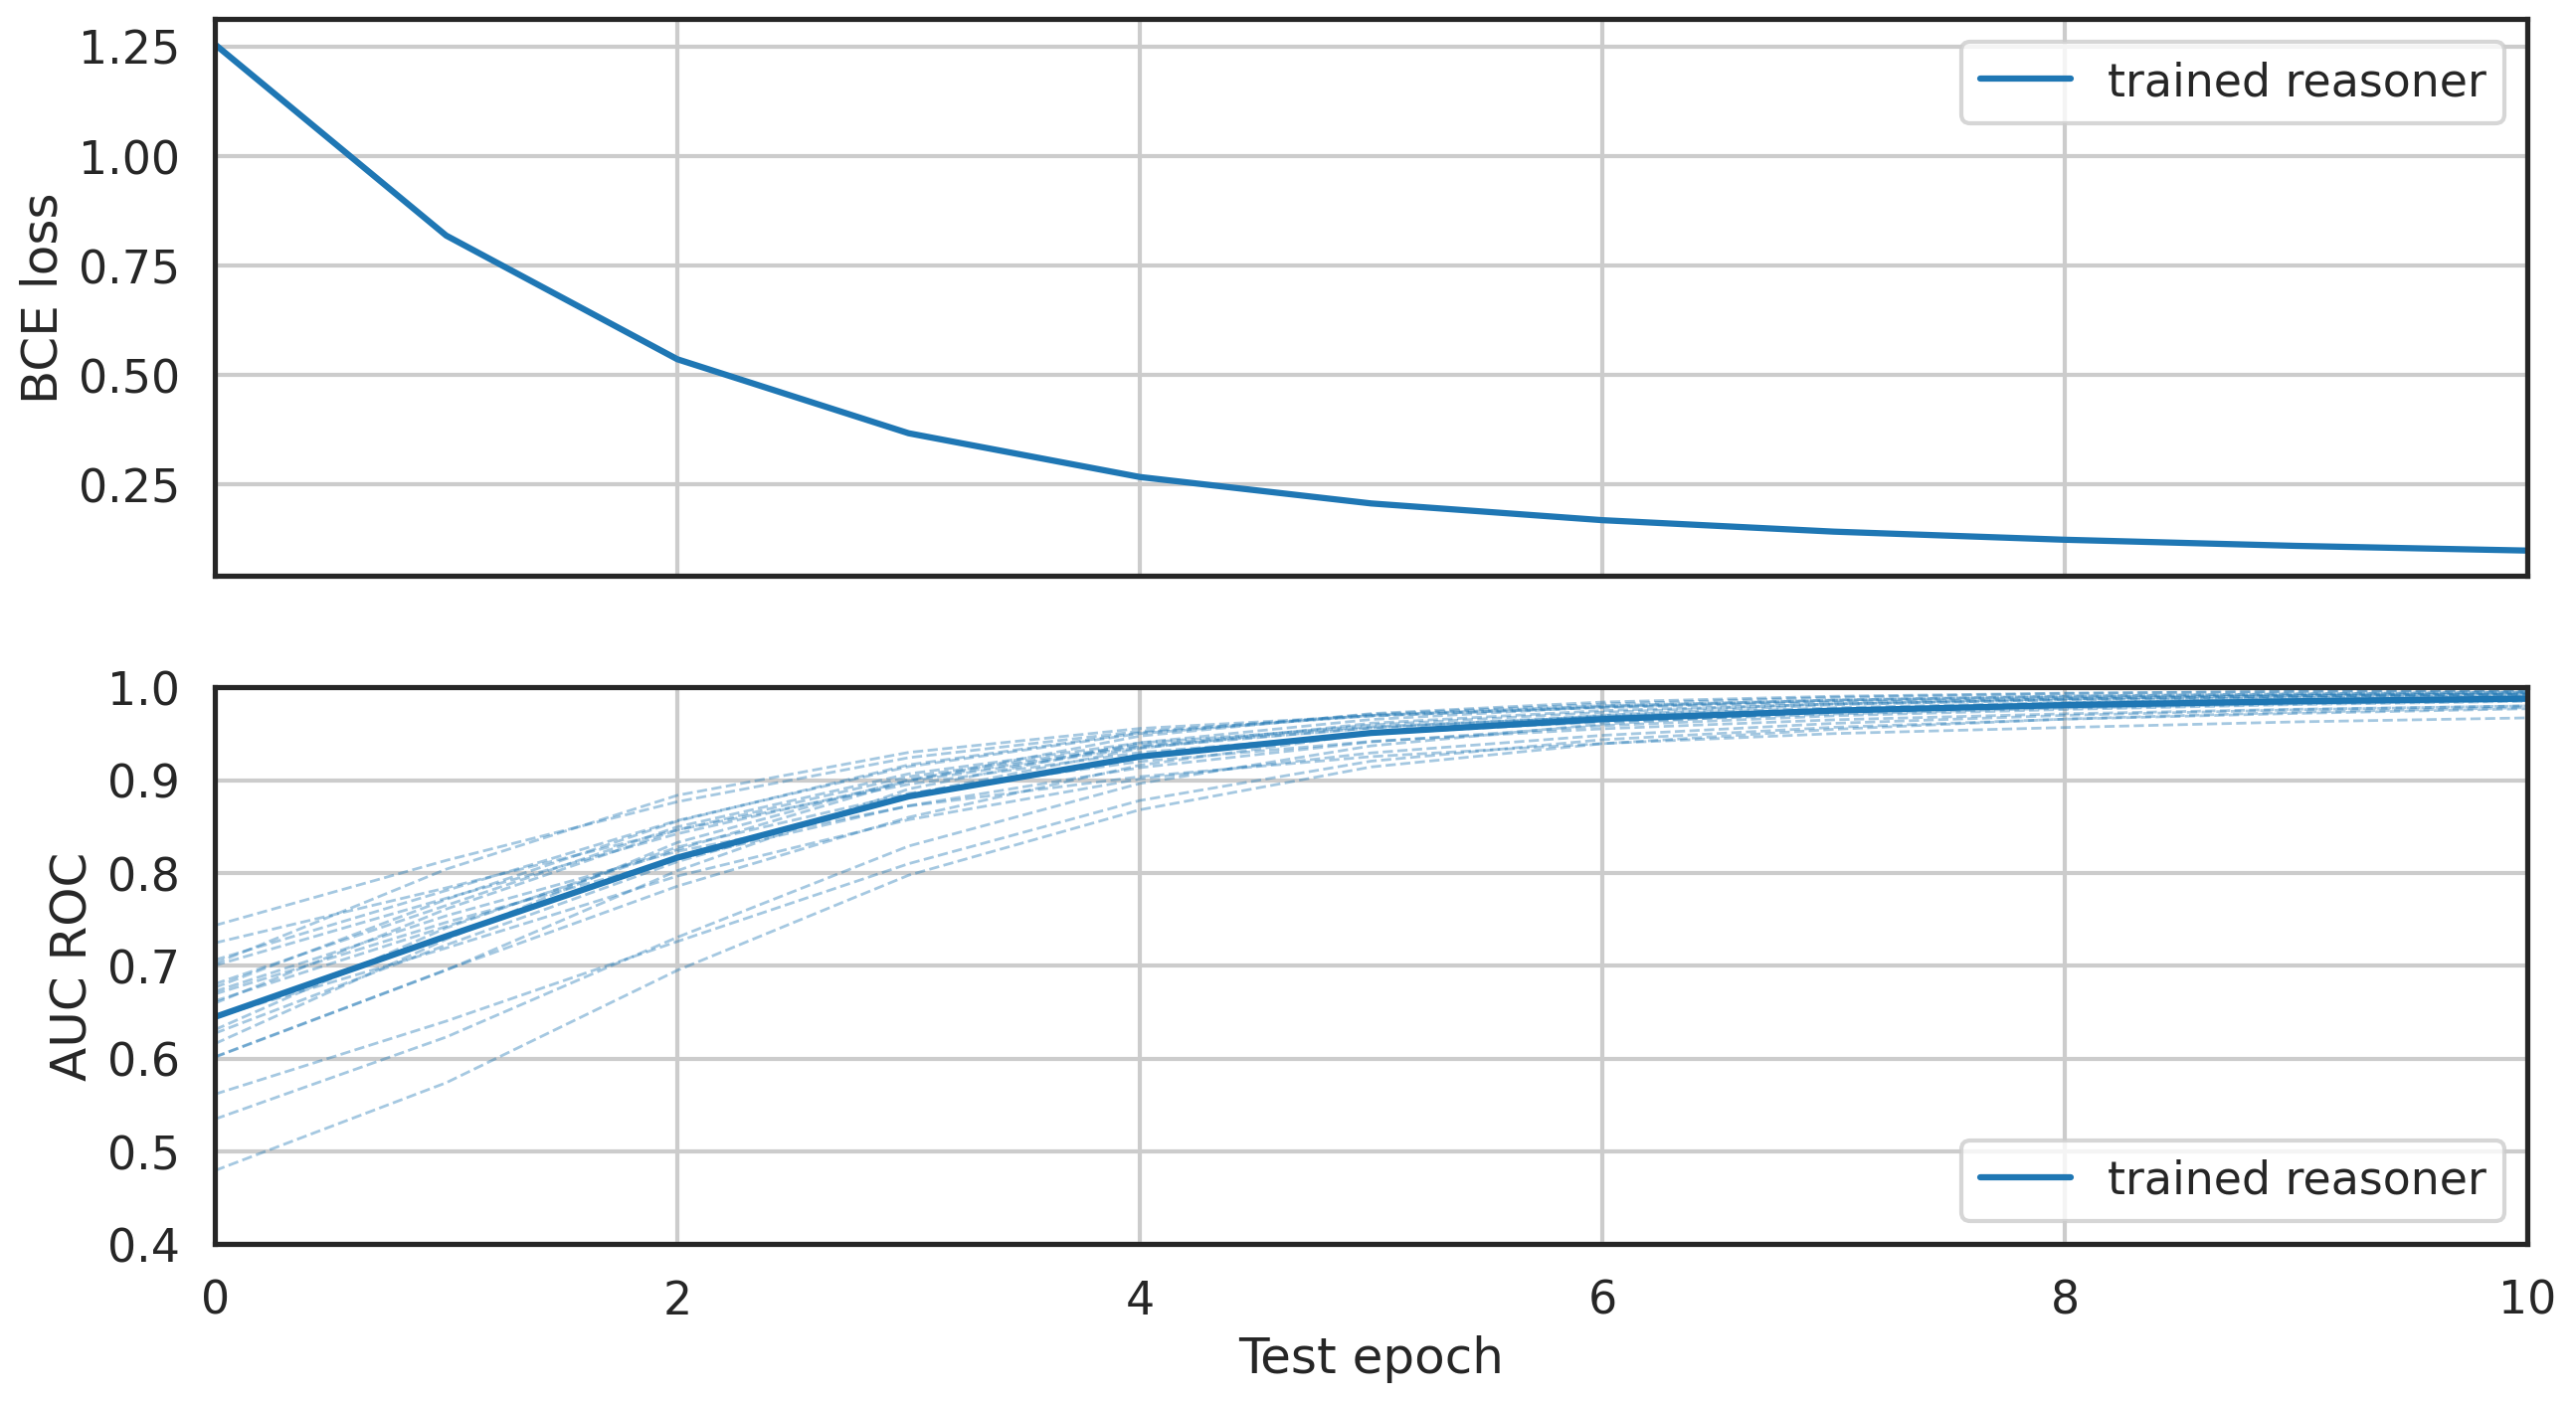

             mean       std     micro
acc      0.965475  0.015139  0.965475
prec     0.955203  0.028009  0.955763
recall   0.880968  0.043686  0.882015
f1       0.916446  0.035920  0.917409
auc_roc  0.987779  0.007922  0.988713
auc_pr   0.971422  0.016957  0.973744


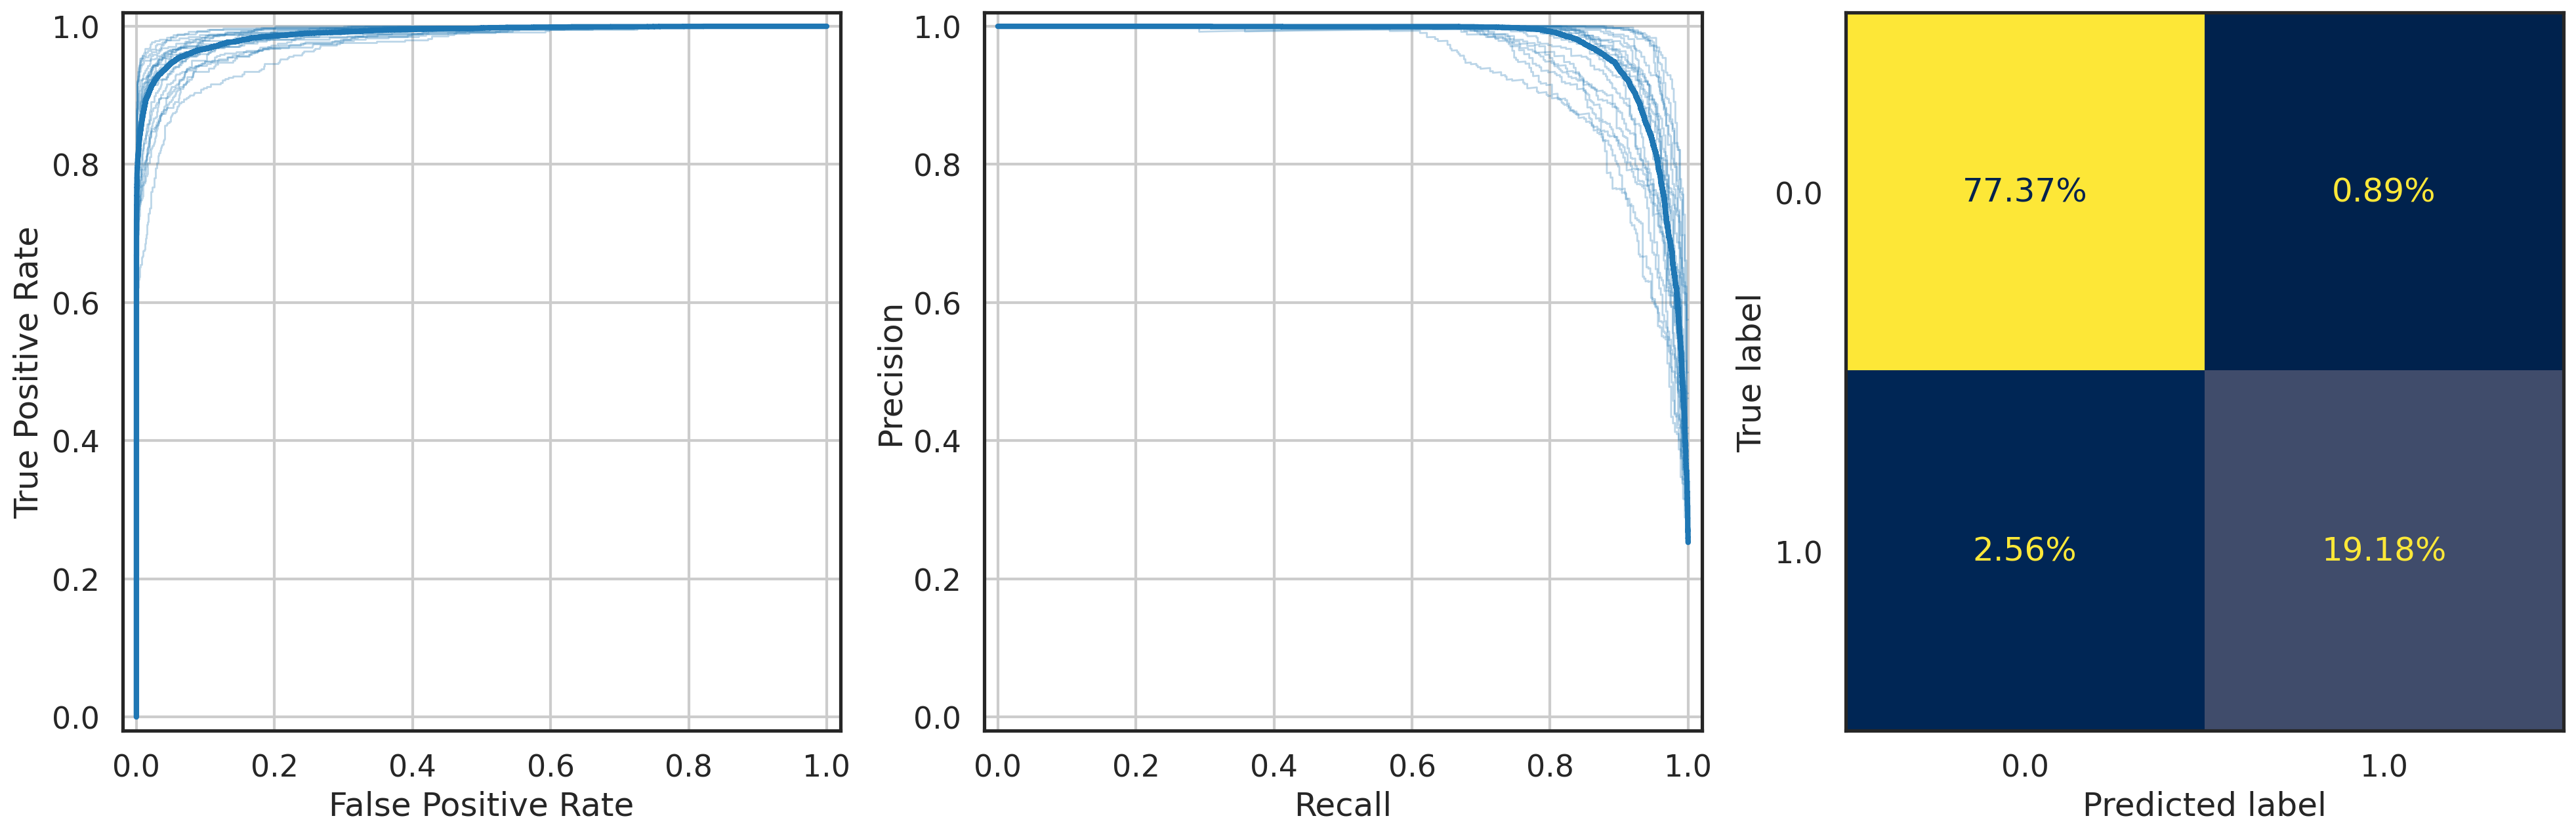

In [6]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te_good))#, Y_te_rand=Y_te_rand))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print(report(test_onto, y_te, np.array(Y_te_good), idx_te, save=base+'/%-trained'))
#print(report(test_onto, y_te, np.array(Y_te_rand), idx_te, save=base+'/%-random'))

In [7]:
T.set_printoptions(precision=3)

In [8]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random.random() * (len(encoders ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append( F.l1_loss(input, trained_reasoner.and_nn(im_mod(input, input))).item() )


print(input)
print(trained_reasoner.and_nn(im_mod( input, input)))
print(np.mean(losses))

tensor([ 0.0752, -0.0094, -0.1718,  0.1653, -0.0538, -0.0008, -0.1900,  0.2314,
        -0.2005,  0.0050], grad_fn=<SelectBackward0>)
tensor([ 9.4413e-02,  1.5744e-02, -9.4006e-02,  8.5458e-05,  4.3274e-02,
        -1.8463e-03, -1.0429e-01,  3.5918e-02, -7.0189e-02, -1.5304e-02],
       grad_fn=<AddBackward0>)
0.09758319482207298


In [21]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random.random() * (len(encoders ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im_mod(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]).item())
print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im_mod(trained_reasoner.bot_concept[0], input)))
print(np.mean(losses))

tensor([ 0.2587,  0.1570,  0.1469, -0.2327,  0.2619, -0.1117, -0.0018, -0.0452,
        -0.0605, -0.1022], grad_fn=<SelectBackward0>)
tensor([ 0.2484,  0.1499,  0.1042, -0.2253,  0.2488, -0.1096, -0.0050, -0.0337,
        -0.0379, -0.0988], grad_fn=<AddBackward0>)
0.016876158909872173


In [10]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random.random() * (len(encoders ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im_mod(trained_reasoner.top_concept[0], input)), input).item())

print(input)
print(trained_reasoner.and_nn(im_mod(trained_reasoner.top_concept[0], input)))
print(np.mean(losses))

tensor([ 0.0328, -0.2875, -0.1875, -0.0167,  0.1697, -0.2000, -0.1028, -0.3722,
         0.0770, -0.0807], grad_fn=<SelectBackward0>)
tensor([-0.0310, -0.1290, -0.0797,  0.0068,  0.0147, -0.0778, -0.0759, -0.1736,
         0.0635,  0.0362], grad_fn=<AddBackward0>)
0.08799236007034779


In [26]:
losses = []
for _ in range(20):

    encoder = encoders[int(np.round(random.random() * (len(encoders ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    output = trained_reasoner.and_nn(im_mod(trained_reasoner.not_nn(input), input))
    losses.append(F.l1_loss(trained_reasoner.bot_concept[0], output).item())

print(trained_reasoner.bot_concept[0])
print(output)
print(np.mean(losses))

tensor([ 0.2587,  0.1570,  0.1469, -0.2327,  0.2619, -0.1117, -0.0018, -0.0452,
        -0.0605, -0.1022], grad_fn=<SelectBackward0>)
tensor([ 0.0839, -0.0574, -0.0736, -0.1156,  0.1467, -0.0434, -0.1084, -0.2190,
         0.1195,  0.1066], grad_fn=<AddBackward0>)
0.09178195530548691


In [12]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.2587,  0.1570,  0.1469, -0.2327,  0.2619, -0.1117, -0.0018, -0.0452,
        -0.0605, -0.1022], grad_fn=<SelectBackward0>)
tensor([ 0.3023,  0.2244,  0.2153, -0.3046,  0.3299, -0.1540,  0.0038, -0.0118,
        -0.0991, -0.1751], grad_fn=<SqueezeBackward3>)
tensor(0.0512, grad_fn=<L1LossBackward0>)


In [13]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.top_concept[0], output))

tensor([-0.1591, -0.2129, -0.1131,  0.4662,  0.1262,  0.2902,  0.5642,  0.1730,
        -0.1271,  0.3226], grad_fn=<SelectBackward0>)


tensor([-0.1006, -0.1636, -0.0800,  0.3705,  0.0448,  0.2314,  0.4407,  0.1590,
        -0.0444,  0.2821], grad_fn=<SqueezeBackward3>)
tensor(0.0638, grad_fn=<L1LossBackward0>)


In [14]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append(F.l1_loss(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.and_nn(im_mod(input2, input3)))), trained_reasoner.and_nn(im_mod(trained_reasoner.and_nn(im_mod(input1, input2)), input3))).item())

print(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.and_nn(im_mod(input2, input3)))))
print(trained_reasoner.and_nn(im_mod(trained_reasoner.and_nn(im_mod(input1, input2)), input3)))
print(np.mean(losses))

tensor([ 0.1164,  0.0195,  0.0330, -0.0968,  0.0851,  0.0172, -0.0441, -0.1065,
         0.0681,  0.0030], grad_fn=<AddBackward0>)


tensor([ 0.0910,  0.0241,  0.0483, -0.0977,  0.0918, -0.0005, -0.0243, -0.1423,
         0.0539, -0.0035], grad_fn=<AddBackward0>)
0.017587524140253663


In [15]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append( F.l1_loss(trained_reasoner.and_nn(im_mod(input1, input2)), trained_reasoner.and_nn(im_mod(input2, input1))).item())

print(trained_reasoner.and_nn(im_mod(input1, input2)))
print(trained_reasoner.and_nn(im_mod(input2, input1)))

print(np.mean(losses))

tensor([ 0.0672,  0.0605, -0.0203, -0.0603,  0.0754, -0.0147, -0.0568, -0.1259,
         0.0360,  0.0237], grad_fn=<AddBackward0>)
tensor([ 0.1016,  0.0942, -0.0213, -0.0441,  0.0486,  0.0126, -0.0414, -0.0994,
         0.0294,  0.0010], grad_fn=<AddBackward0>)
0.015440697502344846


In [16]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(F.l1_loss(input1, trained_reasoner.and_nn(im_mod(input1, trained_reasoner.top_concept[0]))).item())

print(input1)
print(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.top_concept[0])))

print(np.mean(losses))

tensor([-0.1756, -0.1937,  0.0193,  0.0207, -0.2022,  0.0467,  0.0119, -0.3805,
        -0.0392, -0.2627], grad_fn=<SelectBackward0>)
tensor([-0.1490, -0.1636, -0.0520,  0.0780, -0.1424,  0.0811, -0.0090, -0.2315,
         0.0204, -0.0226], grad_fn=<AddBackward0>)
0.06461446182802319


In [17]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append( T.sigmoid(trained_reasoner.sub_nn(im_mod(input1, trained_reasoner.top_concept[0]))).item())
print(np.mean(losses))

0.9983007192611695


In [18]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im_mod(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.999927282333374


In [19]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im_mod(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.999927282333374
